# 1) ML Capstone: Stock Options - Data Gathering & Processing

<font color='blue'> Scripts by Kevin Jeswani
<br>
WeCloudData Bootcamp 2022 (Part-time Cohort)<br> </font>

First financial FOREX ticker and other indicator data is gathered from the EODHD API

The set of scripts in the folder 'FOREX_Forecasting_Scripts' are segmented for the purpose of clarity & convenience <br>
The following is the suggested order for running the scripts:
- '1_KJ_Forex_TS_Forecasting_DataGathering_Processing.ipynb' **This Script** - Gathering data from the EODHD API, inspecting, cleaning, merging the forex data
- '2_KJ_Forex_TS_Forecasting_EDA_VARMAX_Prophet.ipynb' - Exploratory data analysis (correlation), classical time series analysis (ACF/PACF) + VARMAX, Facebook Prophet
- '3_KJ_Forex_TS_Forecasting_SkForecast.ipynb' - Boosted tree  (XGB, LGBM, CatBoost, RandomForest ensemble) time series regression models, with backtesting/timeseries cross validation.
- '4_KJ_Forex_TS_Forecasting_LSTM.ipynb' - LSTM (RNNs) models.

Data is gathered from:
- The EOD Historical Data API: https://eodhistoricaldata.com/
- Unofficial Python SDK for EODHD: https://github.com/LautaroParada/eod-data
- OECD.Stats
<br>

## Standard Imports and General Settings

In [2]:
from eod import EodHistoricalData #Python SDK for EODHD API - extract stock data
import timeit #To time processes

# Data Processing
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn', override copywithsetting
import numpy as np
import csv
import time
import datetime # required for creating date-time arrays or unix time codes for EODHD intra-day
from flatten_json import flatten
import json
from textwrap import wrap #string processing

# Data Storage
import csv
import h5py # For writing, reading, managing results as hdf5 files
from pandas import HDFStore
import h5glance # For visualizing HDF5 file structures and data types
from h5glance import H5Glance
import tables #pytables

# Plotting
import matplotlib as mpl #Matplot lib
import matplotlib.pyplot as plt #pyplot
import plotly.express as px #plotly express
import plotly.io as pio
import plotly.graph_objects as go #for candlestick charts
import kaleido #sub-library required for saving plotly
import seaborn as sns #seabprm
sns.set() 

# API requests
import requests

In [56]:
root = r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Capstone\Forex\Scripts'
root_raw = r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Capstone\Forex\Scripts\Scraped_Data'
root_results = r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Capstone\Forex\Scripts\Results'

In [4]:
# API key
EOD_key ='635fc245aa7a83.09456999'

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

## Stock Ticker Data

Define currencies to examine - create currency pairs

In [8]:
from itertools import combinations
currencies = ['EUR','USD','CAD','JPY','CHF','INR']
curr_pairs = ["".join(map(str, comb)) for comb in combinations(currencies, 2)] #Create currency pairs 
curr_pairs_alt = [wrap(c,3)[1]+wrap(c,3)[0] for c in curr_pairs] #alternative currency pair order as EOD has missing data

https://eodhistoricaldata.com/financial-apis/intraday-historical-data-api/

Function to get intraday stock tick data from the API and a function to input the appropriate unix date-time range

In [9]:
def datetime_to_unix(dt,direction=0):
    '''Converts string date-time (dt_string) stamp to unix format
    dt = the date time element being converted
    direction = date-time string to unix (0, default) or unix to date-time string (1)
    '''
    if direction == 0: #default convert date-time string to unix format  
        dt_mod = time.mktime(datetime.datetime.strptime(dt, "%Y-%m-%d").timetuple())
    else:
        dt_mod = datetime.datetime.fromtimestamp(dt)
    return dt_mod

In [10]:
def EODH_get_intraday(tickers,start_date,end_date,increment,api_key,root_save,h5db,appendh5=False):
    '''
    Calls EODHD using subscription api_key to get historical data on intra-day stock price
    Reference: https://eodhistoricaldata.com/financial-apis/intraday-historical-data-api/
    See for API inputs: https://github.com/LautaroParada/eod-data#stock-market-prices-splits-and-dividends-data-api-arrow_up
    Input:
        tickers = list of strings for 'ticker' symbols; each in format of '{SYMBOL_NAME}.{EXCHANGE_ID}'; {EXCHANGE ID} may be omitted in some cases
        start_date = string in date format 'YYYY-MM-DD' for beginning of range to be extracted
        end_date = string in date format 'YYYY-MM-DD' for beginning of range to be extracted
        increment = increment for ticker data for {1 min, 5 min, 1h} use {'1m','5m','1h'}
            NOTE: The maximum periods between ‘from’ and ‘to’ are 120 days for 1-minute intervals, 
            600 days for 5-minute intervals and 7200 days for 1-hour intervals.
        api_key = API key registered with a subscription to EODHD
        root_save = folder where extracted data will be stored
        h5db = .h5 database file name as string
      Output: 
        options_base = df containing base information categorized by expiration date for each ticker input
        options_contracts = df containing information for each individual contract at each expiration date
        .csv will be saved for each ticker for the time range, similarly .h5 files for each added to db and appended
    '''
    client = EodHistoricalData(api_key)
    for t, ticker in enumerate(tickers):
        try: #some currency pair orders won't work
            # Call the API - string date-time needs to be converted to unix format
            response = client.get_prices_intraday(ticker, interval=increment,
                                                  from_=datetime_to_unix(start_date), to=datetime_to_unix(end_date))
            # Load list containing json into df
            df_intraday = pd.json_normalize(response)
            # Convert 'timestamp' column from unix to datetime string by df.apply
            df_intraday['timestamp'] = df_intraday['timestamp'].apply(datetime.datetime.fromtimestamp)
        except: #if not able to find 'timestamp' try different ordering
            ticker2 = tickers_alt[t] #only for forex - get inverse curr pair
            # Call the API - string date-time needs to be converted to unix format
            response = client.get_prices_intraday(ticker2, interval=increment,
                                                  from_=datetime_to_unix(start_date), to=datetime_to_unix(end_date))
            # Load list containing json into df
            df_intraday = pd.json_normalize(response)
            # Convert 'timestamp' column from unix to datetime string by df.apply
            df_intraday['timestamp'] = df_intraday['timestamp'].apply(datetime.datetime.fromtimestamp)
            # Correct for currency pair inversion
            df_intraday['open'] = 1/df_intraday['open']
            df_intraday['high'] = 1/df_intraday['high']
            df_intraday['low'] = 1/df_intraday['low']
            df_intraday['close'] = 1/df_intraday['close']
        
        # Add a tag of the origin ticker as a column to the dfs - keep original ticker regardless of order
        ticker_tag = [ticker]*len(df_intraday) #generate a column with the ticker
        df_intraday.insert (0, "Ticker", ticker_tag)
        
        # Save the dfs to csv for each ticker
        fid = r'\Ticker_' + ticker.replace(".","_") + '_' +increment+'_'+ start_date + '_to_' + end_date +'.csv'
        df_intraday.to_csv(root_save+fid)
        
        # Save to hdf5 database
        hdf = pd.HDFStore(root_save+h5db) #initialize access to the db
        df_intraday = df_intraday.fillna(0.0).copy() #fill null values with 0 to avoid write issues
        df_intraday=df_intraday.astype({"volume":"int64"}) # WARNING this seems to be breaking the h5storage!
        # Append to table if appendh5=True; required for doing 1min increments and breaking calls up by month
        df_intraday.to_hdf(hdf,key='/'+ticker.replace(".","_")+"_"+increment,format='table',append=appendh5) 
        
        # Store the base data table containing summary of each call-put set per expiration date
        if t==0: #if it's the first ticker set the global intraday tick df
            intradayticks = df_intraday
        else: #append to existing base and contracts df if exists
            intradayticks = pd.concat([intradayticks,df_intraday])
            #reset index then drop old index
            intradayticks = intradayticks.reset_index()
            intradayticks = intradayticks.drop(['index'],axis=1)
    hdf.close()   
    return intradayticks

### Collect 1min Ticker Data for FOREX

THe API only has data in 5-min/1h increments after Oct 2020. To get this fine grained information we need to do 1min increments, for which data is available back to 2009 or so. The API can only process 120 days per call if 1min increments use.

In [11]:
tickers = [c+'.FOREX' for c in curr_pairs]
tickers_alt = [c+'.FOREX' for c in curr_pairs_alt] #alternative order tickers

In [ ]:
# Generate monthly date-time list using pd.date_range (MS=month start)
daterange = pd.date_range(start='2010-10-01',end='2022-11-01',freq='MS',inclusive="both") #monthly to keep it simple
daterange = [str(daterange) for daterange in daterange.strftime('%Y-%m-%d')] #convert to string list for input into EOD function
for m,mo in enumerate(daterange[:-1]): #last element does not need to be run
    # For loop to grab intraday ticker data for selected symbols
    # Set appendh5 = True so each month will be added to existing tables
    intradayticks = EODH_get_intraday(tickers=tickers,start_date=daterange[m],end_date=daterange[m+1],increment='1m',
                                   api_key=EOD_key,root_save=root_raw,h5db=r'\FOREX_Intraday.h5',appendh5=True)

Clean up tables if necessary - load from .csv files then add to h5 file <br>

In [ ]:
h5db=r'\FOREX_ID.h5' #Cleaned up database for intraday ticks
daterange = pd.date_range(start='2010-10-01',end='2022-11-01',freq='MS',inclusive="both") #monthly to keep it simple
daterange = [str(daterange) for daterange in daterange.strftime('%Y-%m-%d')] #convert to string list for input into EOD func
increment = '1m'
#load each csv for each ticker and each month in the range
for t, ticker in enumerate(tickers):
    for m,mo in enumerate(daterange[:-1]): #last element does not need to be run
        start_date = daterange[m]
        end_date = daterange[m+1]
        fid = r'\Ticker_' + ticker.replace(".","_") + '_' +increment+'_'+ start_date + '_to_' + end_date +'.csv'
        df_in = pd.read_csv(root_raw+fid) #load each csv file
        df_in = df_in.drop(['Unnamed: 0'],axis=1) #drop the old index
        df_in = df_in.fillna(0.0).copy() #fill null values with 0 to avoid write issues
        df_in = df_in.astype({"volume":"int64"})
        if ticker =='JPYCHF.FOREX':
            if df_in['close'].max() >0.1: #JPYtoCHF needs to be manually corrected
                df_in['close']=df_in['close']/100
                df_in['open']=df_in['open']/100
                df_in['low']=df_in['low']/100
                df_in['high']=df_in['high']/100
        hdf = pd.HDFStore(root_raw+h5db) #initialize access to the db
        df_in.to_hdf(hdf,key='/'+ticker.replace(".","_")+"_1m",format='table',append=True)

**NOTE** JPY:CHF is Multiplied by 100, need to correct for this

## End-of-Day (EOD) & Resampled Intra-Day Tick Data

The EODHD API can be called for EOD data separately. This is more usefull with stocks (which one explored before FOREX), as it gives split/dividend adjusted data. We do not require the adjustment factor for FOREX. Simply load and resample the data down to daily intervals.

In [12]:
# Load h5 and examine contents
fid = root_raw+r'\FOREX_ID.h5'
h5glance.install_ipython_h5py_display()
f = h5py.File(fid, "r+")
f

C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Capstone\Forex\Scripts\Scraped_Data\FOREX_ID.h5/ (4 attributes)
├CADCHF_FOREX_1m	(2 children) (15 attributes)
├CADINR_FOREX_1m	(2 children) (15 attributes)
├CADJPY_FOREX_1m	(2 children) (15 attributes)
├CHFINR_FOREX_1m	(2 children) (15 attributes)
├EURCAD_FOREX_1m	(2 children) (15 attributes)
├EURCHF_FOREX_1m	(2 children) (15 attributes)
├EURINR_FOREX_1m	(2 children) (15 attributes)
├EURJPY_FOREX_1m	(2 children) (15 attributes)
├EURUSD_FOREX_1m	(2 children) (15 attributes)
├JPYCHF_FOREX_1m	(2 children) (15 attributes)
├JPYINR_FOREX_1m	(2 children) (15 attributes)
├USDCAD_FOREX_1m	(2 children) (15 attributes)
├USDCHF_FOREX_1m	(2 children) (15 attributes)
├USDINR_FOREX_1m	(2 children) (15 attributes)
└USDJPY_FOREX_1m	(2 children) (15 attributes)

In [133]:
ID_daily = {} #initialize empty dictionary for resampled intraday ticks 
ID_15min = {} #for 15min tick data
# Logic for apply resampling function
logic = {'open':'first','high':'max','low':'min','close':'last','volume':'sum','date':'first','Ticker':'first'} 
#IDTicks = {} Data requires too much ram to store in variables if not being used
# Load Intra-Day Tick Data, resample to daily and hourly
for t,ticker in enumerate(tickers):
    #load from h5 for each ticker
    increment = '1m'
    df_ID = pd.read_hdf(root_raw+r'\FOREX_ID.h5',mode='r+',key='/'+ticker.replace(".","_")+'_'+increment) 
    # Process date-time
    df_ID["timestamp"] = df_ID["timestamp"].astype('datetime64[ns]') #convert object type to datetime for resampling
    df_ID['date'] = [d.date() for d in df_ID['timestamp']] # Add a column for the date (only) - extract from timestamp
    df_ID.set_index('timestamp',inplace=True) #set the date-time of as the index
    
    # Manual correction of issues spotted - only to clos
    if ticker =='EURCHF.FOREX':
        # One month of EURCHF was multiplied by 100 - fix this issue
        df_ID.loc[(df_ID['close']>2),['close','low','high','open']] = \
        df_ID.loc[(df_ID['close']>2),['close','low','high','open']].apply(lambda x: x/100)
    elif ticker =='JPYINR.FOREX':
        # One month of JPYINR was inversed - fix this issue
        df_ID.loc[(df_ID['close']>1),['close','low','high','open']] = \
        df_ID.loc[(df_ID['close']>1),['close','low','high','open']].apply(lambda x: 1/x)
    
    # Apply custom aggregators to open, high, low, & close
    df_15min = df_ID.resample(rule='15min').apply(logic) #resample by:business-month end='BM', daily='D'
    df_daily = df_ID.resample(rule='D').apply(logic)
    df_15min['date'] = df_15min['date'].astype('datetime64[ns]') #convert object type to datetime for merging (due to resampling)
    df_daily['date'] = df_daily['date'].astype('datetime64[ns]')
    # Rules & other params: https://towardsdatascience.com/using-the-pandas-resample-function-a231144194c4
    df_15min = df_15min.dropna() #drop values that could not be calculated (days without trades)
    df_daily = df_daily.dropna() 
    
    #Save to database file
    hdf = pd.HDFStore(root_raw+'\FOREX_15min.h5') #initialize access to the db
    df_15min.to_hdf(hdf,key='/'+ticker.replace(".","_")+"_15m",format='table',append=False)
    hdf.close()
    hdf = pd.HDFStore(root_raw+'\FOREX_EOD.h5') #initialize access to the db
    df_daily.to_hdf(hdf,key='/'+ticker.replace(".","_")+"_1d",format='table',append=False)
    hdf.close()
    
    #Store to dict for use in this notebook
    ID_daily[ticker] = df_daily

## Technical Indicators

https://eodhistoricaldata.com/financial-apis/technical-indicators-api/

The technical indicators selected from the EODHD API are as follows: <br>
<br> </br>
<u> Moving Averages (and moving average-derived, non-normalized indicators)</u> 
- Exponential Moving Average indicator (ema) - https://www.investopedia.com/terms/e/ema.asp
- Simple Moving Average indicator (sma) - https://www.investopedia.com/terms/s/sma.asp
- Weighted Moving Average (wma) <br> - https://www.investopedia.com/ask/answers/071414/whats-difference-between-moving-average-and-weighted-moving-average.asp
- Moving Average Convergence/Divergence, using default values fast_period=12, slow_period=26, signal_period = 9 - https://www.investopedia.com/terms/m/macd.asp;  <br>
- Bollinger Bands (bbands) - https://www.investopedia.com/terms/b/bollingerbands.asp; industry-standard 20-day period specified will return upper,middle, and lower bands = 3 time-series
- Parabolic SAR Indicator (sar): https://www.investopedia.com/trading/introduction-to-parabolic-sar/ - default acceleration factors used
<br> </br>
<br> </br>
<u> Indices/Indicators: </u> (provides values between 0 to 1 or 0 to 100 for ease of interpretation and cross-stock comparison/model building<br>
- Relative Strength Index (rsi) - https://www.investopedia.com/terms/r/rsi.asp; industry standard 14-day period used
- Stochastic Technical Indicator (stochastic): https://www.investopedia.com/terms/s/stochasticoscillator.asp - default fast K=14,slow K=3, and slow D=3-day periods used; K and D values returned = 2 features
- Stochastic RSI (stochrsi): https://www.investopedia.com/terms/s/stochrsi.asp - default fast K & D=14-day periods used; returns fastK and fastD values

- Average Directional Movement Index (adx): https://www.investopedia.com/terms/a/adx.asp - industry standard 14-day periods specified
- Directional Movement Index (dmi): https://www.investopedia.com/terms/d/dmi.asp industry standard 14-day periods specified
<br> </br>
<br> </br>
21,50,and 200-day periods (industry standard) specified for remaining indicators, if not specified above; which results in 3 time-series per indicator.

In [13]:
def EODHD_get_indicators(tickers, indicators, start_date,end_date,periods,api_key,root_save,h5db,appendh5=False):
    '''
        Calls EODHD using subscription api_key to get historical data on technical analysis indicators
        Reference: https://eodhistoricaldata.com/financial-apis/technical-indicators-api/
        See for API inputs: https://github.com/LautaroParada/eod-data#stock-market-prices-splits-and-dividends-data-api-arrow_up
        Input:
            tickers = list of strings for 'ticker' symbols; each in format of '{SYMBOL_NAME}.{EXCHANGE_ID}'; {EXCHANGE ID} may be omitted in some cases
            indicators = string list of indicator codes supported by the API
            start_date = string in date format 'YYYY-MM-DD' for beginning of range to be extracted
            end_date = string in date format 'YYYY-MM-DD' for beginning of range to be extracted
            periods = int list of periods used in calculating the indicators
            api_key = API key registered with a subscription to EODHD
            root_save = folder where extracted data will be stored
            h5db = .h5 database file name as string
          Output: 
            Indicators
            .csv will be saved for each ticker for the time range, similarly .h5 files for each added to db and appended
        '''
    client = EodHistoricalData(api_key)
    # Generate base df containing every date in the input date range - all indidicator dfs will be merged into this
    daterange = pd.date_range(start=start_date,end=end_date,freq='D',inclusive="both") 
    df_indicators = pd.DataFrame(data=daterange,columns=['date'])
    for t, ticker in enumerate(tickers): #loop through each ticker
        ticker2 = tickers_alt[t] #only for forex - get inverse curr pair if necessary
        df_indicators = pd.DataFrame(data=daterange,columns=['date']) #setup the base df for all indicators collected for the ticker
        for indicator in indicators: #loop through each indicator
            if indicator not in ['macd','sar','stochrsi','stochastic','adx','dmi','rsi','bbands']: #periods are not applicable to these indicators, use default values
                for period in periods: #loop through each period 
                    response = client.get_instrument_ta(ticker, function=indicator, from_=start_date, to=end_date, period=period)
                    if response == None:
                        # Call the API for the technical indicator - adjusted for splits only to be consistent with the adjustment ratio for EOD ticks
                        response = client.get_instrument_ta(ticker2, function=indicator, from_=start_date, to=end_date, period=period)
                    # Load list containing json into df, cleanup
                    df = pd.json_normalize(response)
                    df['date'] = df['date'].astype('datetime64[ns]') #ensure datetime64 type to match other dfs
                    df = df.add_suffix('_'+str(period)) #add a suffix for the period to give meaning to variables
                    # Merge to the base df
                    df_indicators = pd.merge(df_indicators,df,how='left',left_on='date',right_on='date_'+str(period))
                    df_indicators = df_indicators.drop(['date_'+str(period)],axis=1)
            elif indicator in ['rsi','adx','dmi','bbands']: #typically use 14-/20day periods only
                if indicator =='bbands':
                    p = 20
                else:
                    p = 14 
                # Call the API - steps as above but no period specification
                response = client.get_instrument_ta(ticker, function=indicator, from_=start_date, to=end_date,period=p)
                if response == None:
                    response = client.get_instrument_ta(ticker2, function=indicator, from_=start_date, to=end_date,period=p)
                # Load list containing json into df, cleanup
                df = pd.json_normalize(response)
                df['date'] = df['date'].astype('datetime64[ns]') #ensure datetime64 type to match other dfs   
                # Merge to the base df
                df_indicators = pd.merge(df_indicators,df,how='left',left_on='date',right_on='date')  
            else: #4 indicators take default values as industry standards
                # Call the API - steps as above but no period specification
                response = client.get_instrument_ta(ticker, function=indicator, from_=start_date, to=end_date)
                if response == None:
                    response = client.get_instrument_ta(ticker2, function=indicator, from_=start_date, to=end_date)
                # Load list containing json into df, cleanup
                df = pd.json_normalize(response)
                df['date'] = df['date'].astype('datetime64[ns]') #ensure datetime64 type to match other dfs   
                # Merge to the base df
                df_indicators = pd.merge(df_indicators,df,how='left',left_on='date',right_on='date')
        
        # Add a tag of the origin ticker as a column to the dfs
        ticker_tag = [ticker]*len(df_indicators) #generate a column with the ticker
        df_indicators.insert (0, "Ticker", ticker_tag)
        # CLeanup - drop null entries, reset the index, drop the extra column
        df_indicators = df_indicators.dropna()
        df_indicators = df_indicators.reset_index()
        df_indicators = df_indicators.drop(['index'],axis=1)
        
        # Save the dfs to csv for each ticker
        fid = r'\Indicators' + ticker.replace(".","_")+'_'+ start_date + '_to_' + end_date +'.csv'
        df_indicators.to_csv(root_save+fid)
        
        # Save to hdf5 database
        hdf = pd.HDFStore(root_save+h5db) #initialize access to the db
        df_indicators = df_indicators.fillna(0.0).copy() #fill null values with 0 to avoid write issues
        
        # Append to table if appendh5=True; required for doing 1min increments and breaking calls up by month
        df_indicators.to_hdf(hdf,key='/'+ticker.replace(".","-"),format='table',append=appendh5) 
        
        # Store the base data table containing summary of each call-put set per expiration date
        if t==0: #if it's the first ticker set the global df
            technicalInds = df_indicators
        else: #append to existing df if exists
            technicalInds = pd.concat([technicalInds,df_indicators])
            #reset index then drop old index
            technicalInds = technicalInds.reset_index()
            technicalInds = technicalInds.drop(['index'],axis=1)
            
    hdf.close()   
    return technicalInds

In [37]:
indicators = ['ema','sma','wma','rsi','bbands','adx','dmi','stochrsi','stochastic','sar','macd']
typ_periods=[21,50,200]
Indicators = EODHD_get_indicators(tickers=tickers,start_date='2010-01-01',indicators=indicators,end_date='2022-11-02',periods=typ_periods,
                                  api_key=EOD_key,root_save=root_raw,h5db=r'\FOREX_Indicators.h5',appendh5=True)

Writing to the DB seems to be an issue sometimes - process from csv files if necessary

In [41]:
h5db=r'\FOREX_Indicators.h5' #Cleaned up database for intraday ticks
start_date = '2010-01-01'
end_date = '2022-11-02'
#load each csv for each ticker and each month in the range
for t, ticker in enumerate(tickers):
    fid = r'\Indicators' + ticker.replace(".","_") + '_' + start_date + '_to_' + end_date +'.csv'
    df_in = pd.read_csv(root_raw+fid) #load each csv file
    df_in = df_in.drop(['Unnamed: 0'],axis=1) #drop the old index
    df_in = df_in.fillna(0.0).copy() #fill null values with 0 to avoid write issues
    hdf = pd.HDFStore(root_raw+h5db) #initialize access to the db
    df_in.to_hdf(hdf,key='/'+ticker.replace(".","_"),format='table',append=True)

## Load EOD Data & Merge to indicators; Process Indicators

In [139]:
# load EOD price data & Indicators from hdf5 file
for t,ticker in enumerate(tickers):
    df_eod = pd.read_hdf(root_raw+r'\FOREX_EOD.h5',mode='r+',key='/'+ticker.replace(".","_") +'_1d')
    df_ind = pd.read_hdf(root_raw+r'\FOREX_Indicators.h5',mode='r+',key='/'+ticker.replace(".","_") )
    if t==0:
        EOD = df_eod
        Indicators = df_ind
    else:
        EOD = pd.concat([EOD,df_eod])
        Indicators = pd.concat([Indicators,df_ind])

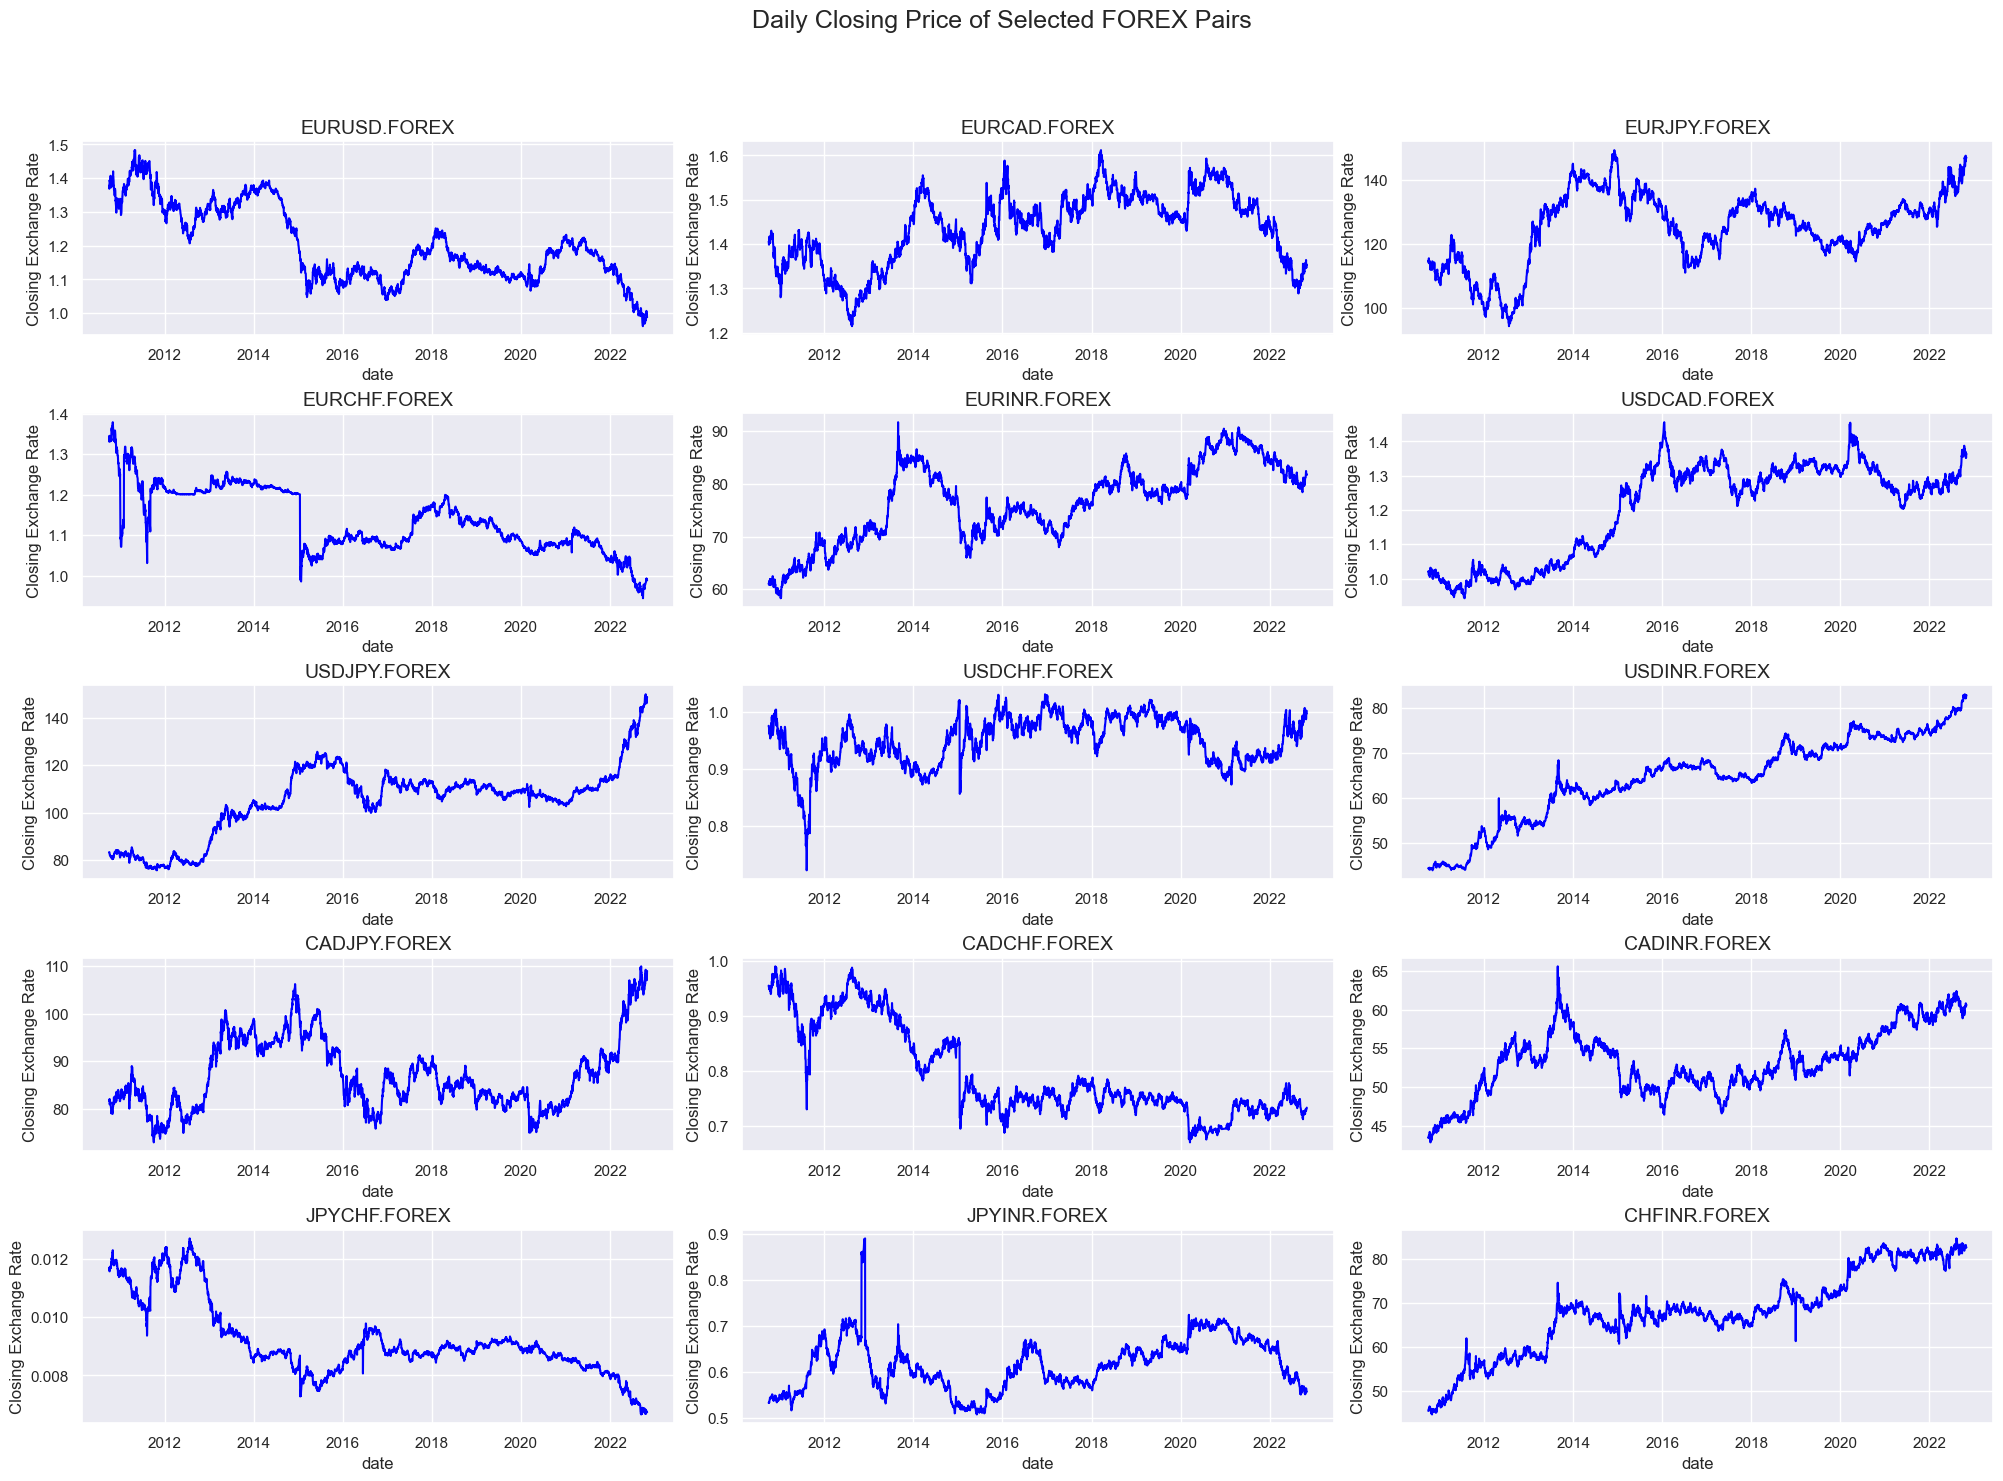

In [176]:
# Plot all end of day close to verify values are sound after modifications
fig,axs = plt.subplots(nrows=int(round(len(tickers)/3,0)),ncols= 3,figsize=(20,14))
# Loop over each ticker, access their close price, plot on individual subplots denoted by ax_i
colorscheme = ['red','blue','green','black']
#linescheme = ['-','--','-','--','-','--','-','--']
for ticker, ax_i in zip(tickers,axs.ravel()):
    df_eod = EOD[EOD['Ticker']==ticker] #load the df of the ticker
    #df_ind = Indicators[Indicators['Ticker']==ticker]
    sns.lineplot(x='date',y='close',data=df_eod,ax=ax_i,color=colorscheme[1],) #plot with seaborn
    # Set title and y label
    ax_i.set_title(ticker,fontsize=14)
    ax_i.set_ylabel('Closing Exchange Rate')
fig.suptitle("Daily Closing Price of Selected FOREX Pairs",fontsize=18,y=1.05) #main title slight elevated above subplots
fig.tight_layout(pad=0.5) #inter-plot padding
fid = r'\AllClosingPrices_wma.png'
fig.savefig(root_results+fid, format='png', dpi=600,bbox_inches='tight') #save to png

### Merge Indicators and EOD ticker data

In [181]:
Indicators['date'] = Indicators['date'].astype('datetime64[ns]') #ensure datetime64 type to match other dfs   
df_EOD_merge = pd.merge(EOD,Indicators,how='left',left_on=['Ticker','date'],right_on=['Ticker','date'],indicator=True)

In [182]:
df_EOD_merge = df_EOD_merge.drop(df_EOD_merge[df_EOD_merge['_merge']!='both'].index,axis=0) #drop rows that did not merge
df_EOD_merge = df_EOD_merge.reset_index() #reset the index
df_EOD_merge = df_EOD_merge.drop(['index'],axis=1) #drop old index column

### Plot Merged Data to confirm values make sense

Plot all closing exchange rates with weighted moving average (WMA) to identify issues in data gathering - any spotted issues are implemented above in the resampling script

In [205]:
def timeplots(df,tickers,x_,y_series,y_label,title,root_save):
    '''
    Generate subplots of multiple stock/forex timeseries
    Inputs: 
        df = dataframe of timeseries
        tickers = string list of currency pairs or stocks to examine
        x,y_series = string or stringlist (for y) for variables to be plotted from the df
        ylabel = y-axis label
        title = overall figure title
        root_save = root where fig will be saved
    Returns:
        subplots, saves fig to specified root as png
    '''
    # Plot all end of day close to verify values are sound after modifications
    fig,axs = plt.subplots(nrows=int(round(len(tickers)/3,0)),ncols= 3,figsize=(20,14))
    # Loop over each ticker, access their close price, plot on individual subplots denoted by ax_i
    for ticker, ax_i in zip(tickers,axs.ravel()):
        df_plt = df[df['Ticker']==ticker] #load the df of the ticker
        df_plt.plot(x=x_,y=y_series,ax=ax_i,xlabel='Date',ylabel=y_label,title=ticker)
    fig.suptitle(title,fontsize=18,y=1.02) #main title slight elevated above subplots
    fig.tight_layout(pad=0.5) #inter-plot padding
    fig.savefig(root_save+title+'.png', format='png', dpi=600,bbox_inches='tight') #save to png

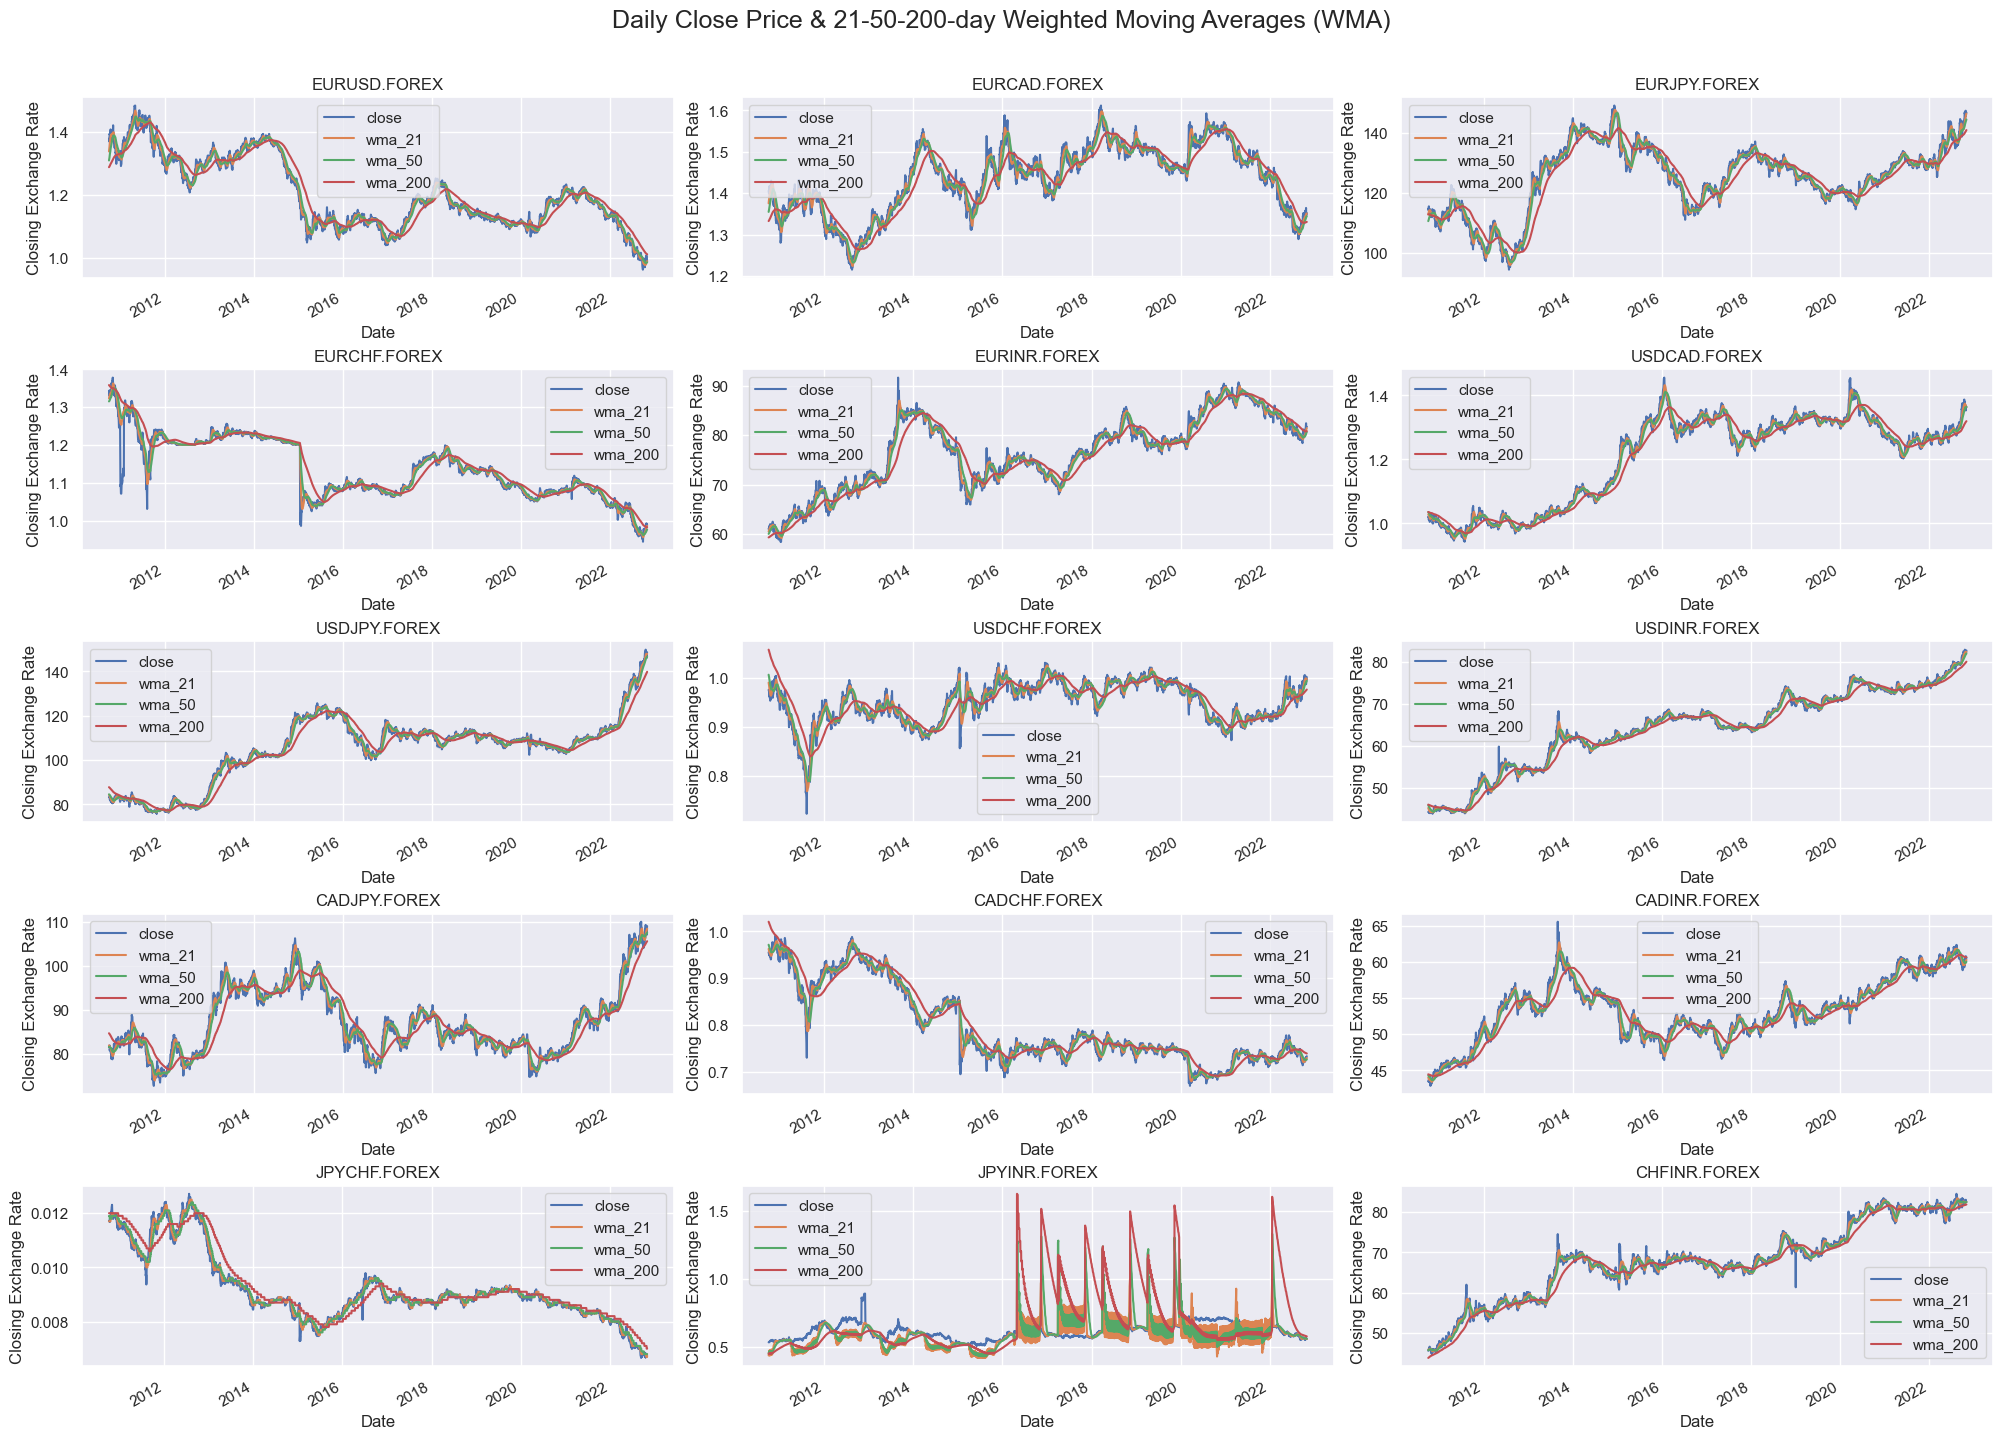

In [209]:
# Examine WMA
inds = ['close','wma_21','wma_50','wma_200'] #selected indicators
timeplots(df=df_EOD_merge,tickers=tickers,x_='date',y_series=inds,y_label='Closing Exchange Rate',
          title='Daily Close Price & 21-50-200-day Weighted Moving Averages (WMA)',root_save=root_results)

In [184]:
# JPY-INR has some inverse wma's/ema's and sma's - apply inverse function
MAs=['wma_21','wma_50','wma_200','sma_21','sma_50','sma_200','ema_21','ema_50','ema_200']
ticker = 'JPYINR.FOREX'
df_EOD_merge.loc[(df_EOD_merge['wma_21']>1)&(df_EOD_merge['Ticker']==ticker),MAs] = \
df_EOD_merge.loc[(df_EOD_merge['wma_21']>1)&(df_EOD_merge['Ticker']==ticker),MAs].apply(lambda x: 1/x)

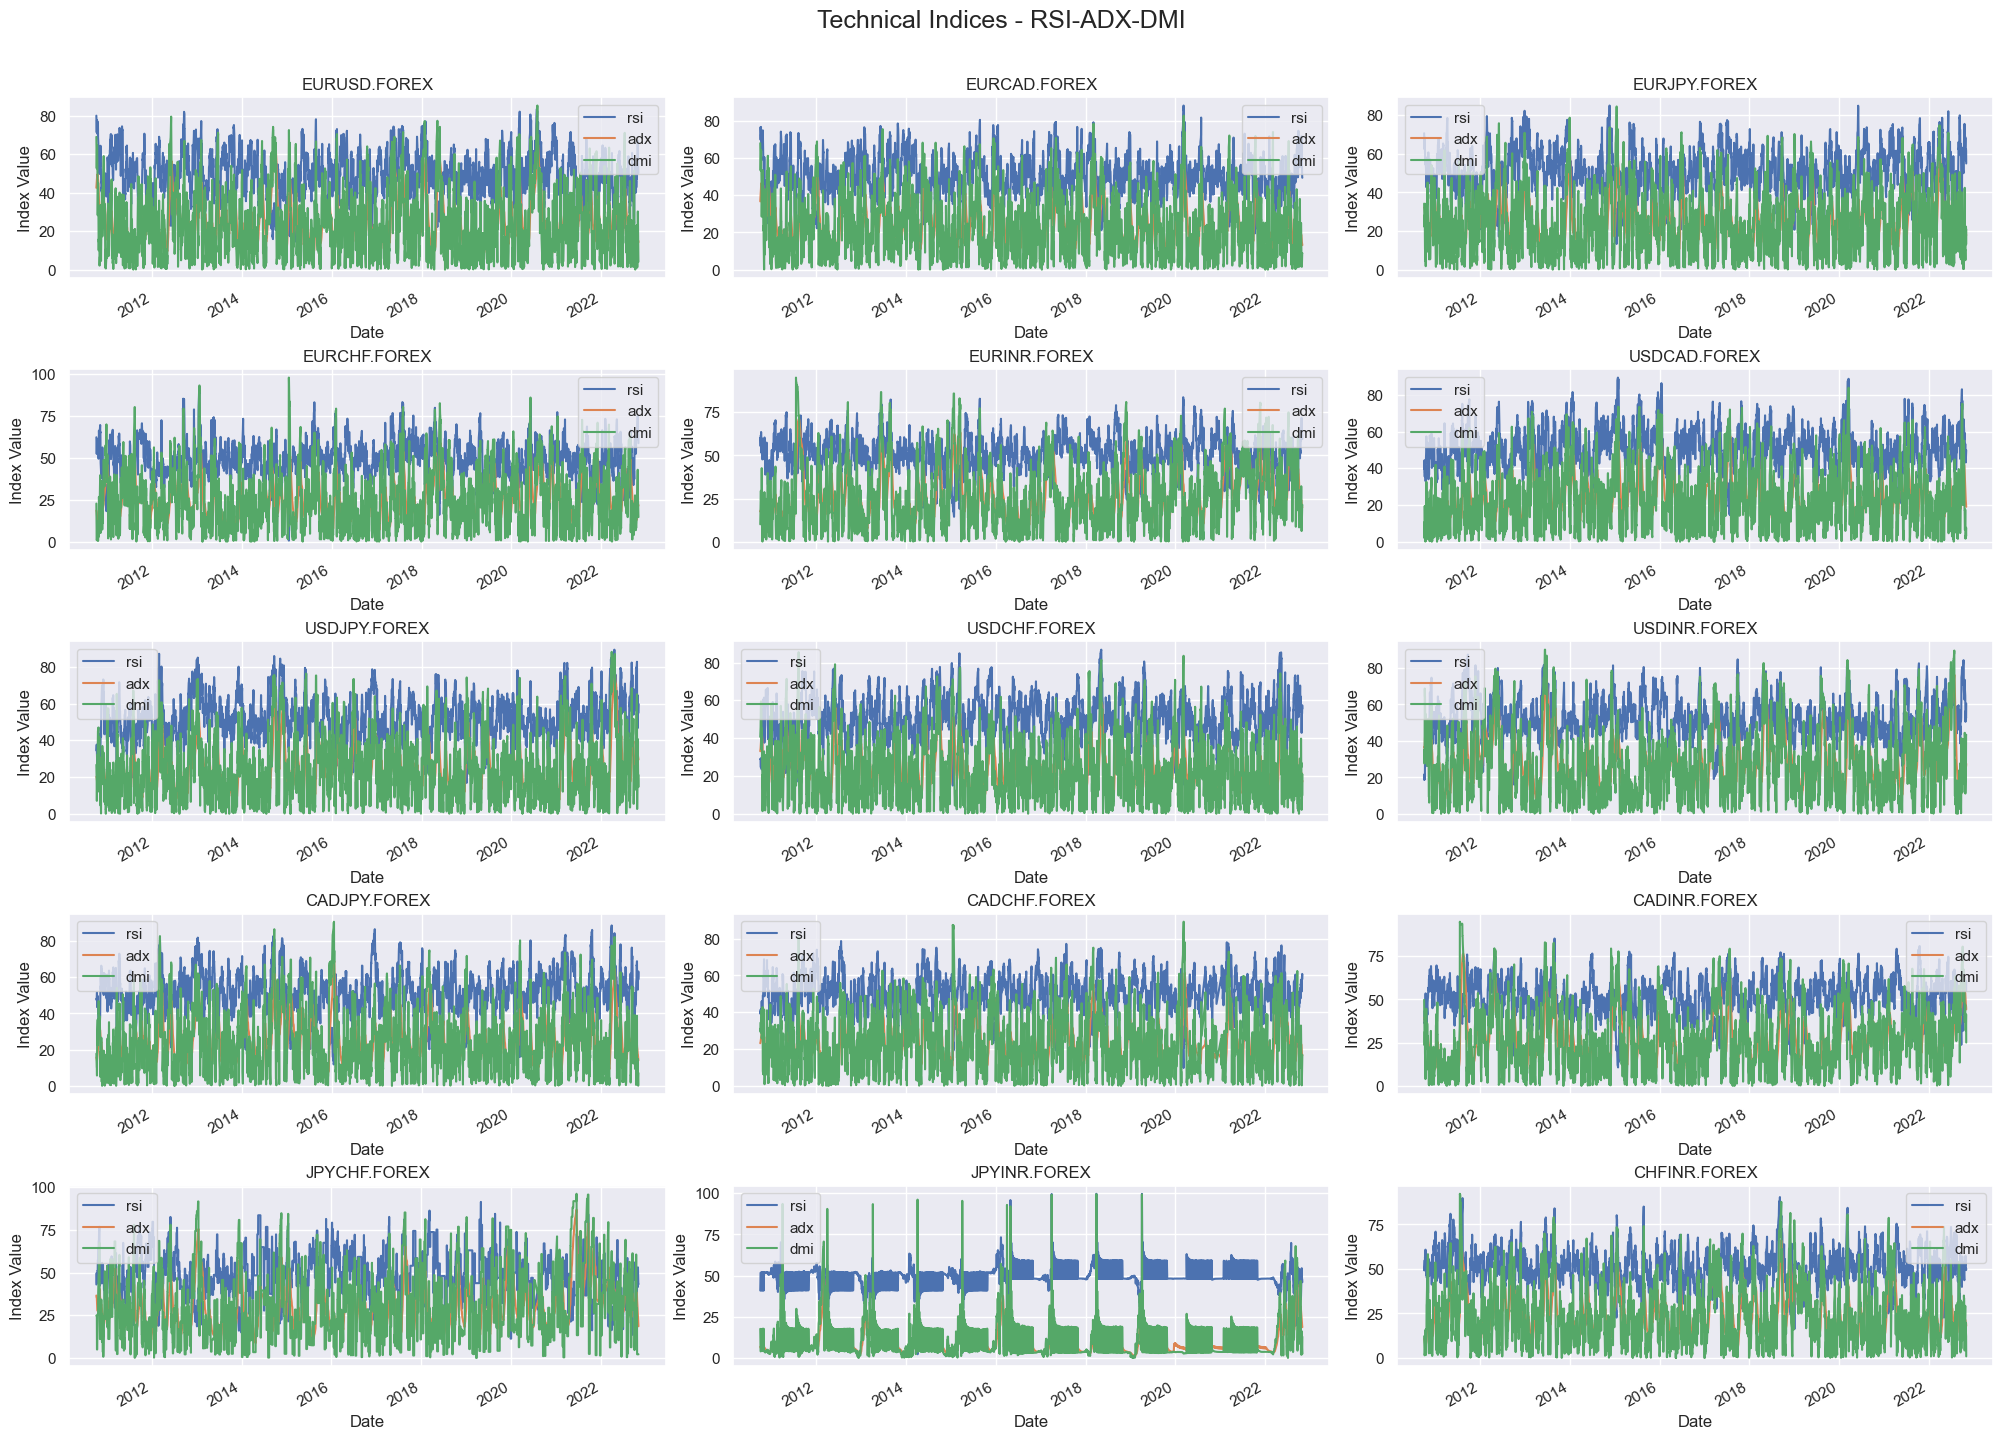

In [212]:
# Examine Indices
inds = ['rsi','adx','dmi'] #selected indicators
timeplots(df=df_EOD_merge,tickers=tickers,x_='date',y_series=inds,y_label='Index Value',
          title='Technical Indices - RSI-ADX-DMI',root_save=root_results)

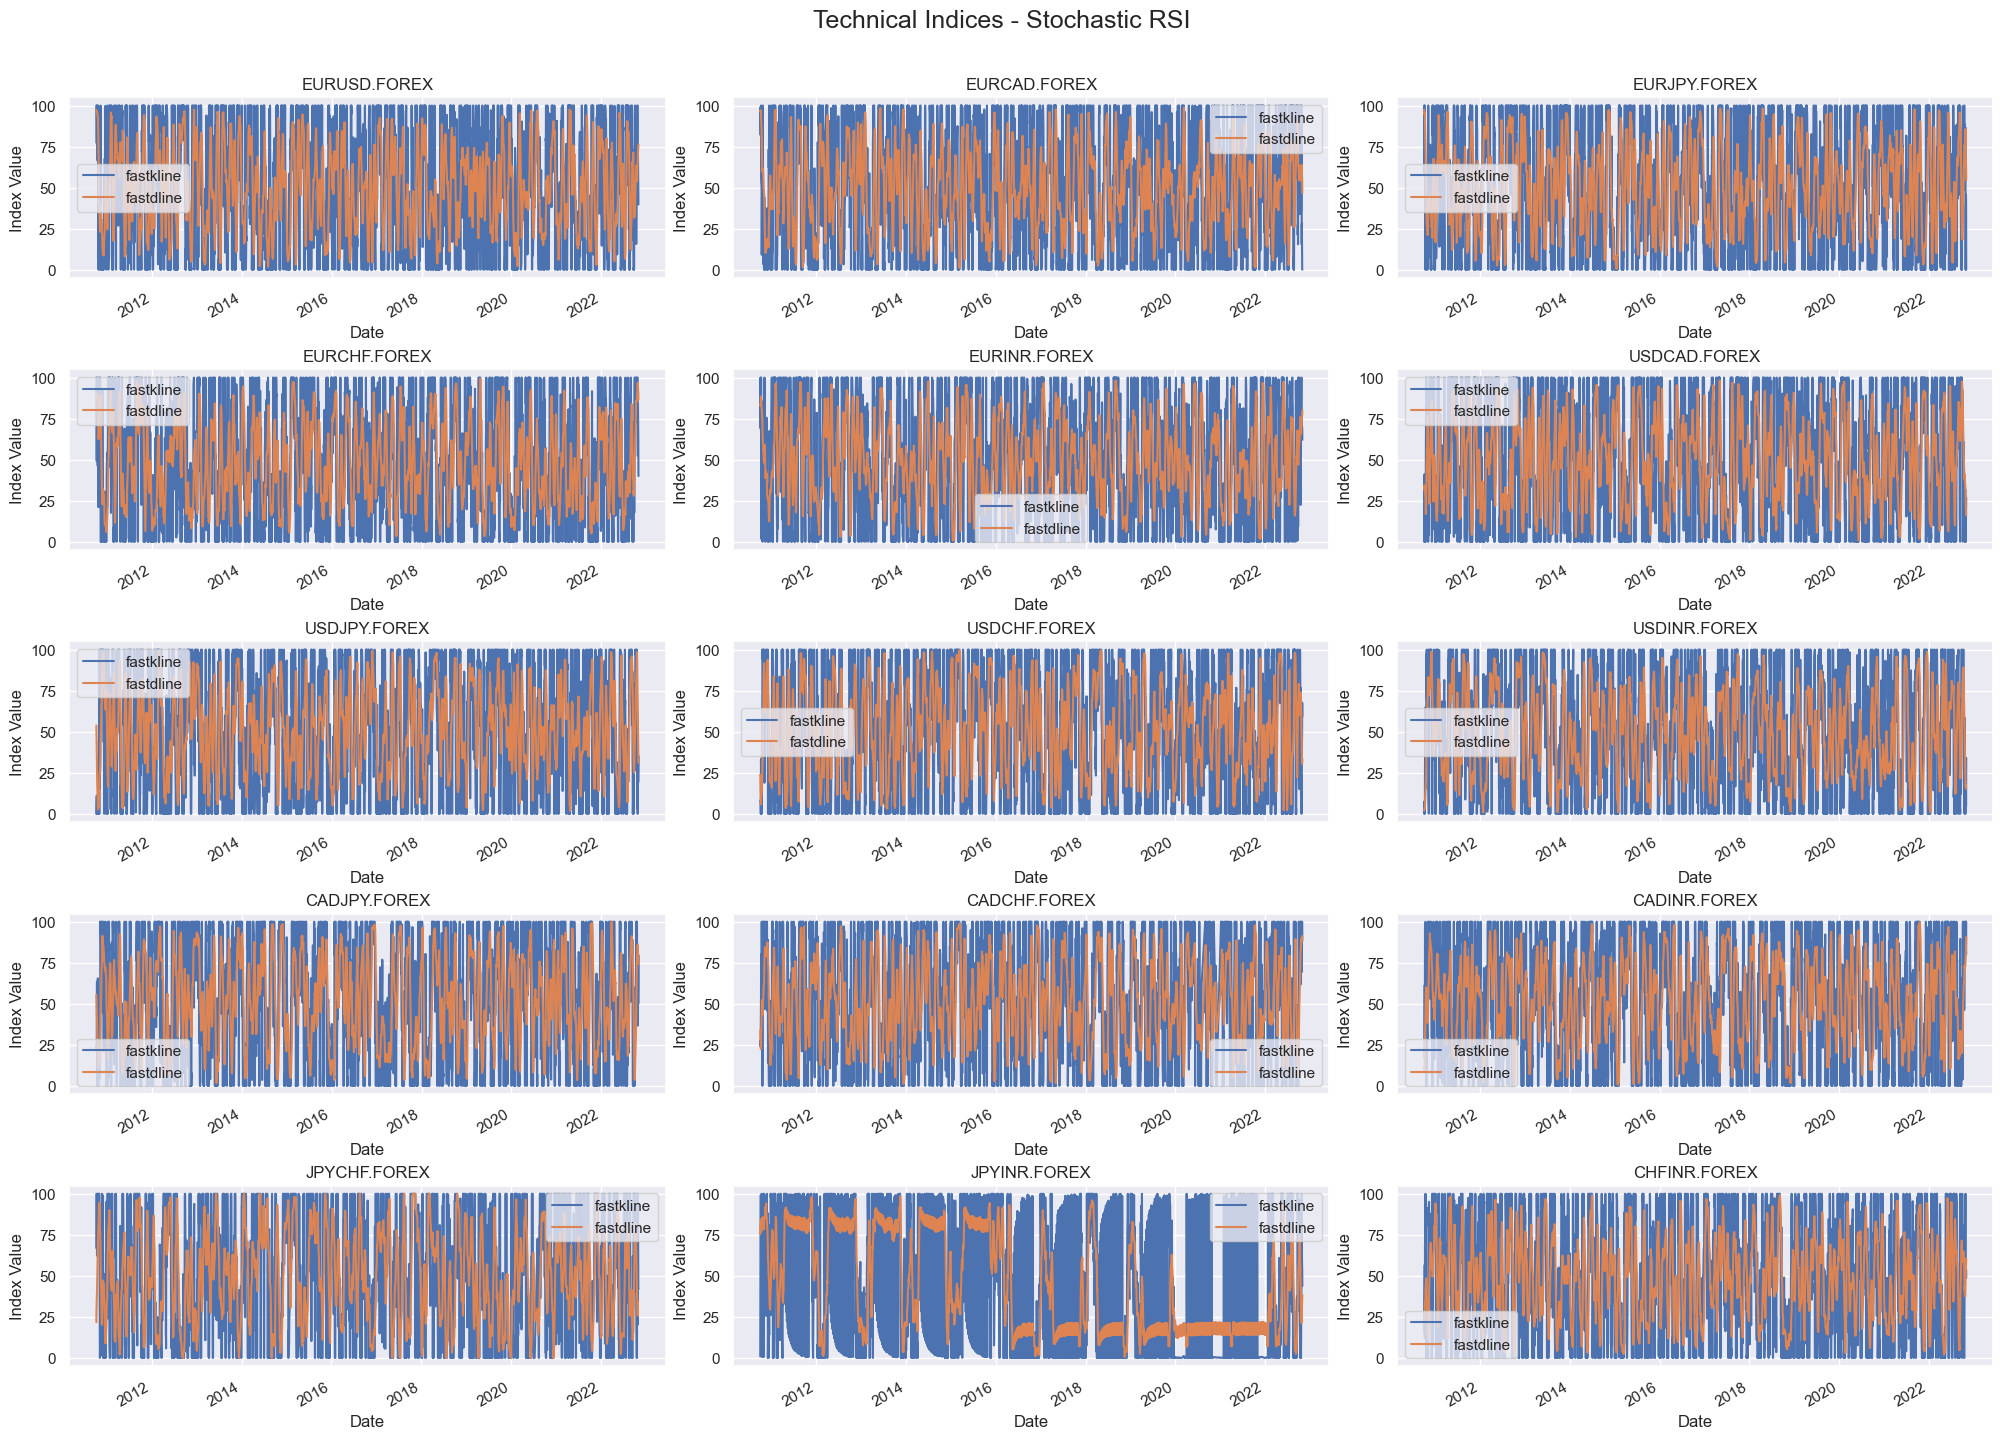

In [215]:
# Examine Indices - Stochastic RSI
inds=['fastkline','fastdline'] #selected indicators
timeplots(df=df_EOD_merge,tickers=tickers,x_='date',y_series=inds,y_label='Index Value',
          title='Technical Indices - Stochastic RSI',root_save=root_results)

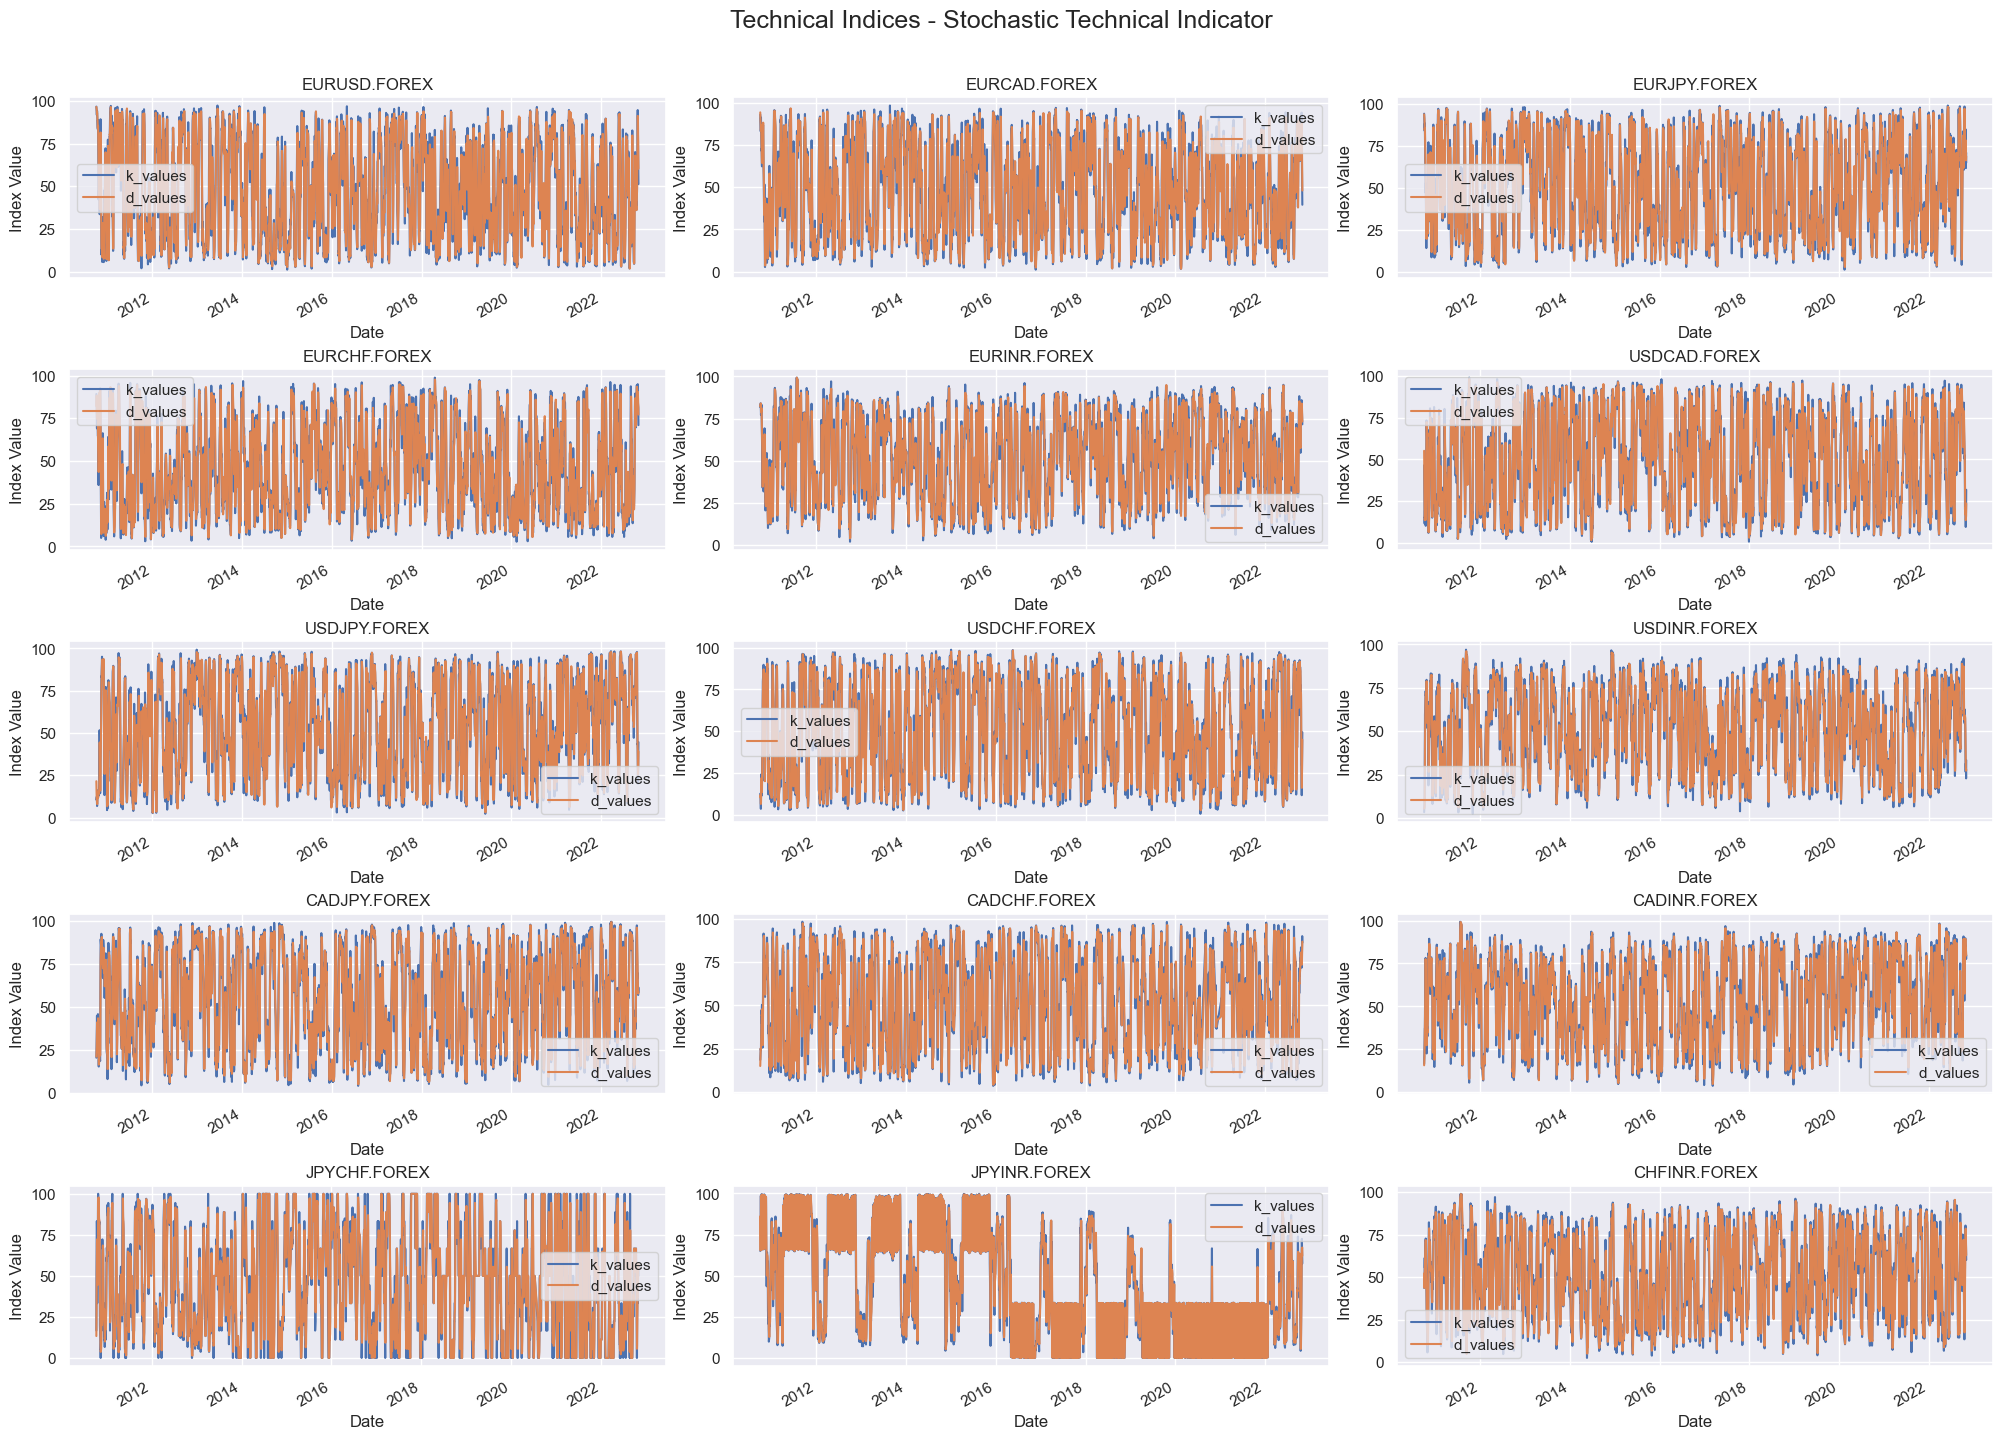

In [216]:
# Examine Indices - Stochastic Technical Indicator
inds=['k_values','d_values'] #selected indicators
timeplots(df=df_EOD_merge,tickers=tickers,x_='date',y_series=inds,y_label='Index Value',
          title='Technical Indices - Stochastic Technical Indicator',root_save=root_results)

It is difficult to tell by visual inspection if the API provided the correct values. **JPYINR** which had other issues in the data appears to standout from the other RSI, ADX, and DMI, & stochastic RSI/technical indicator timeseries. It will be used with caution.

### Process the technical indicators

Normalize MACD following this method: https://medium.com/geekculture/the-normalized-macd-oscillator-a-python-study-55e5b64a1331; Normalize MACD divergence as well

In [217]:
lookback = 100 #100-day period normalizer
for t,ticker in enumerate(tickers):
    macd = df_EOD_merge[df_EOD_merge['Ticker']==ticker]['macd'].to_numpy()
    divergence = df_EOD_merge[df_EOD_merge['Ticker']==ticker]['divergence'].to_numpy()
    macd_norm = np.empty(shape=(len(macd), 1), dtype='float64') #initialize empty array
    divergence_norm = np.empty(shape=(len(macd), 1), dtype='float64') #initialize empty array
    for i in range(lookback,len(macd)): #for every value after the first 100 OHLCs
        if max(macd[(i-lookback):i]) != min(macd[(i-lookback):i]): #when min & max of mac are not equal
            #((macd @ time i)-min(macd in lookback period))/(max(macd in lookback)-min(macd in lookback))
            macd_norm[i] = (macd[i]-min(macd[(i-lookback):i]))/(max(macd[(i-lookback):i])-min(macd[i-lookback:i]))
            #repeat for divergence
            div = (max(divergence[(i-lookback):i])-min(divergence[i-lookback:i]))
            if div <0.00001:
                divergence_norm[i] = 0.0
            else:
                divergence_norm[i] = (divergence[i]-min(divergence[(i-lookback):i]))/div
        else: #otherwise set to 0
            macd_norm[i] = 0.0
            divergence_norm[i] = 0.0
    if t==0: #if first ticker set the aggregated macd to current macd
        macd_norm_all = macd_norm
        divergence_norm_all = divergence_norm
    else: #otherwise append to aggregated macd
        macd_norm_all = np.append(macd_norm_all,macd_norm)
        divergence_norm_all = np.append(divergence_norm_all,divergence_norm)
# Add new column for normalized macd & divergence
df_EOD_merge['macd_norm'] = np.round(macd_norm_all,4) #round to 4 decimal places
df_EOD_merge['divergence_norm'] = np.round(divergence_norm_all,4)

Normalize SAR following this method: https://medium.com/geekculture/the-parabolic-stop-and-reverse-the-full-guide-dedb6ff1c00f

In [224]:
lookback = 100 #100-day period normalizer
for t,ticker in enumerate(tickers):
    sar = df_EOD_merge[df_EOD_merge['Ticker']==ticker]['sar'].to_numpy()
    sar_norm = np.empty(shape=(len(sar), 1), dtype='float64') #initialize empty array
    for i in range(lookback,len(sar)): #for every value after the first 100 OHLCs
        if max(sar[(i-lookback):i]) != min(sar[(i-lookback):i]): #when min & max of mac are not equal
            #((sar @ time i)-min(sar in lookback period))/(max(sar in lookback)-min(sar in lookback))
            sar_norm[i] = (sar[i]-min(sar[(i-lookback):i]))/(max(sar[(i-lookback):i])-min(sar[i-lookback:i]))
        else: #otherwise set to 0
            sar_norm[i] = 0.0
    if t==0: #if first ticker set the aggregated sar to current sar
        sar_norm_all = sar_norm
    else: #otherwise append to aggregated sar
        sar_norm_all = np.append(sar_norm_all,sar_norm)
# Add new column for normalized sar & divergence
df_EOD_merge['sar_norm'] = np.round(sar_norm_all,4) #round to 4 decimal places

Normalize Bollinger Bands following: https://kaabar-sofien.medium.com/the-normalized-bollinger-indicator-another-way-to-trade-the-range-back-testing-in-python-db22c111cdde

In [226]:
# Normalize bollinger bands to single indicator
for t,ticker in enumerate(tickers):
    uband = df_EOD_merge[df_EOD_merge['Ticker']==ticker]['uband'].to_numpy() #extract upper band
    lband = df_EOD_merge[df_EOD_merge['Ticker']==ticker]['lband'].to_numpy() #extract lower band    
    curr_price = df_EOD_merge[df_EOD_merge['Ticker']==ticker]['close'].to_numpy() #extract closing price
    bbands_norm = np.empty(shape=(len(uband), 1), dtype='float64') #initialize empty array
    for i in range(0,len(uband)):
        #((curr @ time i)-lower band)/(upper band - lower band))
        div = (uband[i]-lband[i])
        if div < 0.00001:
            bbands_norm[i]
        else:
            bbands_norm[i] = (curr_price[i]-lband[i])/div
        if bbands_norm[i] <-2.0: #place lower limit - adjusted price not supposed to drop much below lower band
            bbands_norm[i] = -2.0
    if t==0: #if first ticker set the aggregated bbands to current bbands
        bbands_norm_all = bbands_norm
    else: #otherwise append to aggregated bbands
        bbands_norm_all = np.append(bbands_norm_all,bbands_norm)
# Add new column for normalized bbands & divergence
df_EOD_merge['bbands_norm'] = np.round(bbands_norm_all,4) #round to 4 decimal places

Convert moving average time-series into one feature that is a count of the number of buy-sell signals based on 3 types of moving averages for 3 periods (essentialy compressing 9 time-series compressed)

In [227]:
# Generate trade signals from moving average parameters
# signal = where 21-day MA crosses over 50-day MA or 50-day crosses 200-day, value = 1.0
MAs = ['sma','ema','wma'] #moving average types
periods = ['21','50','200']
for ma in MAs:
    df_EOD_merge['signal_'+ma+'_'+periods[0]+'_'+periods[1]] = 0.0 #initialize with 0 signal value
    df_EOD_merge['signal_'+ma+'_'+periods[1]+'_'+periods[2]] = 0.0
    # Set signal = 1.0 when short period crosses over and above longer period MA
    df_EOD_merge['signal_'+ma+'_'+periods[0]+'_'+periods[1]] = np.where(df_EOD_merge[ma+'_'+periods[0]]>df_EOD_merge[ma+'_'+periods[1]], 1.0, 0.0)
    df_EOD_merge['signal_'+ma+'_'+periods[1]+'_'+periods[2]] = np.where(df_EOD_merge[ma+'_'+periods[1]]>df_EOD_merge[ma+'_'+periods[2]], 1.0, 0.0)
    # position = day-day difference in signal
    df_EOD_merge['position_'+ma+'_'+periods[0]+'_'+periods[1]] = df_EOD_merge['signal_'+ma+'_'+periods[0]+'_'+periods[1]].diff()
    df_EOD_merge['position_'+ma+'_'+periods[1]+'_'+periods[2]] = df_EOD_merge['signal_'+ma+'_'+periods[1]+'_'+periods[2]].diff()
    # When position=1.0, signal has changed from 0 to 1 = BUY; when position =-1.0 signal changed from 1 to 0 = SELL
df_EOD_merge['ma_position']=df_EOD_merge['position_ema_21_50']+df_EOD_merge['position_ema_50_200'] +df_EOD_merge['position_sma_21_50']+df_EOD_merge['position_sma_50_200'] +df_EOD_merge['position_wma_21_50']+df_EOD_merge['position_wma_50_200']

## FINANCIAL SENTIMENT API

https://eodhistoricaldata.com/financial-apis/sentimental-data-financial-api/

### News

In [228]:
# Select the tickers that have a reasonable amount of results and are worth examining
tickers2 = ['EURUSD.FOREX','JPYUSD.FOREX','CADUSD.FOREX','CHFUSD.FOREX','INRUSD.FOREX']

In [229]:
mergedtickers = ','.join(tickers2)
start_date = '2015-07-07' #where news data appears to start
end_date = '2022-11-02'
client = EodHistoricalData(api_key=EOD_key)
response = client.get_sentiment(s=mergedtickers,from_=start_date,to=end_date)

In [230]:
start_date = '2019-01-01' #where news data appears to start
end_date = '2022-11-02'
for t, ticker in enumerate(tickers2):   
    df = pd.DataFrame.from_dict(response[ticker]) #load each dict to a df
    # Update formatting
    df['date'] = df['date'].astype('datetime64[ns]') #ensure datetime64 type to match other dfs   
    # Add a tag of the origin ticker as a column to the dfs
    ticker_tag = [tickers[t]]*len(df) #generate a column with the ticker
    df.insert (0, "Ticker", ticker_tag)
        
    # Save the dfs to csv for each ticker
    fid = r'\NewSentiment' + ticker.replace(".","_")+'_'+ start_date + '_to_' + end_date +'.csv'
    df.to_csv(root_raw+fid)

    if t==0: #if first ticker set global df to current df
        NewsSentiment = df
    else:
        NewsSentiment = pd.concat([NewsSentiment,df])

Merge to EOD & Indicator data

In [231]:
NewsSentiment = NewsSentiment.rename({'count': 'SentimentCount', 'normalized': 'Sentiment_norm'}, axis='columns')

In [232]:
df_EOD_merge = pd.merge(df_EOD_merge,NewsSentiment,how='left',left_on=['Ticker','date'],right_on=['Ticker','date'],indicator=False)

In [233]:
# Fill null values in the normalized new sentiment data column with 0 = neutral value
df_EOD_merge['Sentiment_norm'] = df_EOD_merge['Sentiment_norm'].fillna(0.0)

Save merged file to a .csv

In [234]:
# Save the dfs to csv for each ticker
fid = r'\FOREX_Merged_EOD_Indicators_Sentiment.csv'
df_EOD_merge.to_csv(root_raw+fid)

## Load Additional Economic Indicators from OECD.Stats

Monthly Immediate Interest Rates

In [235]:
# Load Monthly Immediate Interest Rates
fid=r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Capstone\Forex\ImmediateInterestRatesMonthly.csv'
df_interest = pd.read_csv(fid) #read csv

In [236]:
# Filter for Country and Immediate Interest Rate
df_interest = df_interest[df_interest['LOCATION'].isin(['EA19','USA','JPN','IND','CHE','CAN']) &
                          (df_interest['SUBJECT']=='IRSTCI')]
# Only extract necessary columns
df_interest = df_interest[['LOCATION','TIME','Value']]

Consumer Price Indices

In [237]:
# Load Monthly Immediate Interest Rates
fid=r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Capstone\Forex\Inflation_Monthly.csv'
df_CPI = pd.read_csv(fid) #read csv

C:\Users\kevin\AppData\Local\Temp\ipykernel_23412\1999560388.py:3: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_CPI = pd.read_csv(fid) #read csv


In [238]:
# Filter for Country and Immediate Interest Rate
df_CPI = df_CPI[df_CPI['LOCATION'].isin(['EA19','USA','JPN','IND','CHE','CAN'])]
# Only extract necessary columns
df_CPI = df_CPI[['LOCATION','TIME','Value']]

Merge two macro-econ indicators

In [239]:
df_macroecon = pd.merge(df_interest,df_CPI,how='left',left_on=['LOCATION','TIME'],right_on=['LOCATION','TIME'])

In [240]:
df_macroecon.columns = ['COU','yyyy-mm','Interest_Rate','CPI'] #rename the columns

Merge onto EOD/Indicator/Sentiment db

In [241]:
# Create two lists of country codes for each forex pair - use to join the national interests & CPI 
COU1 = [wrap(c,3)[0] for c in curr_pairs] 
COU2 = [wrap(c,3)[1] for c in curr_pairs]
currcode = ['USD','JPY','EUR','INR','CAD','CHF']
coucode = ['USA','JPN','EA19','IND','CAN','CHE']
# Replace currency code with country code
for c,cur in enumerate(COU1):
    for j,cou in enumerate(currcode):
        if COU1[c] == cou:
            COU1[c] = coucode[j]
        if COU2[c] == cou:
            COU2[c] = coucode[j]

In [242]:
df_EOD_merge.insert(0,'COU1','')
df_EOD_merge.insert(1,'COU2','')

In [243]:
# Initialize new column
for t,ticker in enumerate(tickers):
    df_EOD_merge.loc[df_EOD_merge['Ticker']==ticker,'COU1'] = COU1[t]
    df_EOD_merge.loc[df_EOD_merge['Ticker']==ticker,'COU2'] = COU2[t]

In [244]:
# Add new column in yyyy-mm datetime format for merge
df_EOD_merge['yyyy-mm'] = df_EOD_merge['date'].apply(lambda x: x.strftime('%Y-%m'))

Merge to macro-economic indicators

In [245]:
# Merge onto COU1
df_EOD_merge_final = pd.merge(df_EOD_merge,df_macroecon,how='left',left_on=['COU1','yyyy-mm'],right_on=['COU','yyyy-mm'],indicator='exists')
df_EOD_merge_final = df_EOD_merge_final.drop(['COU'],axis=1) # drop extra country code
df_EOD_merge_final = df_EOD_merge_final.rename(columns={'Interest_Rate': 'interest_COU1','CPI':'CPI_COU1'}) #rename

In [246]:
# Drop duplicates being created for some reason
df_EOD_merge_final = df_EOD_merge_final.drop_duplicates(subset=['Ticker','date'])

In [247]:
# Merge again onto COU2
df_EOD_merge_final = pd.merge(df_EOD_merge_final,df_macroecon,how='left',left_on=['COU2','yyyy-mm'],right_on=['COU','yyyy-mm'],indicator=False)

In [248]:
# Drop duplicates being created for some reason
df_EOD_merge_final = df_EOD_merge_final.drop_duplicates(subset=['Ticker','date'])

In [249]:
df_EOD_merge_final = df_EOD_merge_final.drop(['COU'],axis=1) # drop extra country code
df_EOD_merge_final = df_EOD_merge_final.rename(columns={'Interest_Rate': 'interest_COU2','CPI':'CPI_COU2'}) #rename

In [250]:
df_EOD_merge_final = df_EOD_merge_final.reset_index()
# Process date-time add a timestamp and make it the index
df_EOD_merge_final['timestamp'] = [d.date() for d in df_EOD_merge_final['date']] # Add a column for the date (only) - extract from timestamp
df_EOD_merge_final.set_index('timestamp',inplace=True) #set the date-time of as the index
df_EOD_merge_final = df_EOD_merge_final.drop(['index'],axis=1)

Additional feature engineering to reduce input features

In [251]:
df_EOD_merge_final['interest_ratio'] = df_EOD_merge_final['interest_COU1'] / df_EOD_merge_final['interest_COU2'] #interest rate ratio between two countries
df_EOD_merge_final['CPI_ratio'] = df_EOD_merge_final['CPI_COU1'] /df_EOD_merge_final['CPI_COU2'] #similarly for CPI

Save final merged file to a .csv

In [252]:
# Save the dfs to csv for each ticker
fid = r'\FOREX_Merged_EOD_Indicators_Sentiment_MacroEcon.csv'
df_EOD_merge_final.to_csv(root_raw+fid)

## Additional Data Cleaning

*(Only use for going back and revising data as needed)*

In [ ]:
# Load h5 and examine contents
fid = root_raw+r'\IDTicks.h5'
h5glance.install_ipython_h5py_display()
f = h5py.File(fid, "r+")
f
f.close()

In [ ]:
f.close()

In [ ]:
hdf = pd.HDFStore(fid) #initialize access to the db

In [ ]:
hdf.close()

Dropping Accidental Tables

In [21]:
h5_fid=root_raw+r'\FOREX_Daily.h5'
h5f = tables.open_file(h5_fid, 'r+')
for ticker in tickers[:3]:
     h5f.remove_node('/', ticker.replace(".","_")+"_1d",recursive=True) #recursive to force delete if child tables exists